In [166]:
import matplotlib.pyplot as plt
import cv2
import sys
sys.setrecursionlimit(20000)
from src import *

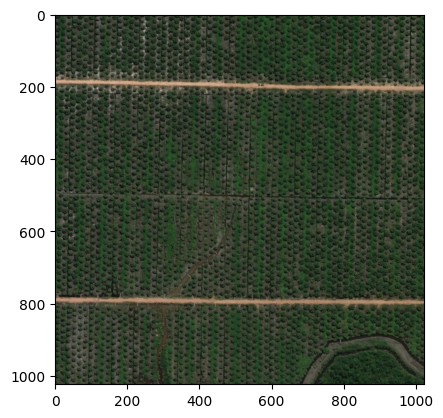

In [167]:
file_name = '../Data/4.jpg'
im = cv2.imread(file_name)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()

In [168]:
def error_l2_norm(x,y,k):
  error = 0
  for i in range(k):
    error += np.linalg.norm(x[i,:]-y[i,:], ord=None)
  return error

def image_cluster(im,k):
  clustered_im = im  
  centroids = np.zeros([k,3]).astype(int)
  new_centroids = np.zeros([k,3])
  for i in range(k):
    centroids[i,:] = [random.randint(0,256),random.randint(0,256),random.randint(0,256)]
    new_centroids[i,:] = ['inf','inf','inf']
  
  cluster_color_id = np.zeros([k,3]).astype(int)
  cluster_color_id[:,0] = np.linspace(0, 255 , num=k)
  cluster_color_id[:,1] = np.linspace(255, 0 , num=k)
  cluster_color_id[0:int((k+1)/2),2] = cluster_color_id[int(k/2):k,0]
  cluster_color_id[int((k+1)/2):k,2] = cluster_color_id[0:int(k/2),0]
  print(cluster_color_id)
  
  n = 0
  dictionary = {}
  while error_l2_norm(centroids,new_centroids,k) >= 0.01 * k:
    centroids = new_centroids
    if n == 0:
      new_centroids = np.zeros([k,3])
      n += 1
    dist = np.zeros([k])
    
    points_in_centroid = np.zeros([k])
    for i in range(im.shape[0]):
      for j in range(im.shape[1]):
        for m in range(k):
          dist[m] = np.linalg.norm(im[i][j]-centroids[m,:], ord=None)
        min_dist = np.argmin(dist)
        dictionary[(i,j)] = min_dist
        points_in_centroid[min_dist] +=1
        new_centroids[min_dist,:] = (new_centroids[min_dist,:] * (points_in_centroid[min_dist] - 1) + im[i][j]) / points_in_centroid[min_dist]
        
  for i in range(im.shape[0]):
    for j in range(im.shape[1]):
      a = dictionary[(i,j)]
      clustered_im[i][j] = cluster_color_id[a,:]

  return clustered_im

[[  0 255 127]
 [127 127 255]
 [255   0   0]]


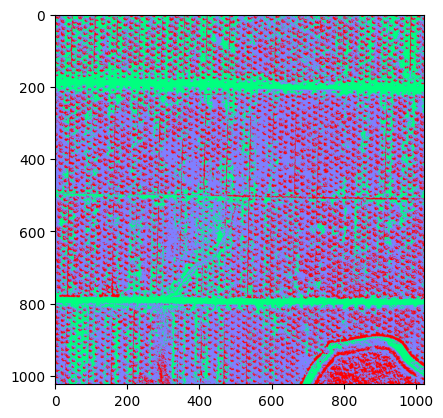

In [169]:
clustered_image = image_cluster(im,3)
plt.imshow(clustered_image)
plt.show()

In [170]:
#Function to give the cluster arrays
#Input: K-Means output image
#Output: Produces k arrays, where in each array the kth cluster pixels will have value 1 and remaining pixels will have value 0

def clusters_segmentation(array_to_be_segmented):
  final_segmented_array = []
  check_value_list = np.unique(array_to_be_segmented)
  #print(check_value_list)
  r = len(array_to_be_segmented)
  c = len(array_to_be_segmented[0])
  for i in  range(len(check_value_list)):
    temp_f = []
    for j in range(r):
      temp_a = []
      for k in range(c):
        if(array_to_be_segmented[j][k] == check_value_list[i]):
          temp_a.append(1)
        else:
          temp_a.append(0)
      temp_f.append(temp_a)
    final_segmented_array.append(temp_f)
  return final_segmented_array


#Function to produce the longest connected component
#Input: Clustered Image
#Output: 2 values: 
# 1) maxi_row which contains maxiumum connected component in each row 
# 2) maxi_col which contains maxiumum connected component in each column
def longest_connected_component(clustered_image):
    
    r = len(clustered_image)
    c = len(clustered_image[0])
 
    maxi_col = []
    temp_count_col = -1

    for j in range(r):
        temp_count  = 0
        for k in range(c-1):
            if(clustered_image[j][k] == 1) and (clustered_image[j][k+1]!=0):
                temp_count += 1
            else:
                temp_count += 1
                if(temp_count > temp_count_col):
                    temp_count_col = temp_count
                    temp_count  = 0 
        maxi_col.append(temp_count_col)
        temp_count_col = 0
  
    maxi_row = []
    temp_count_row = -1
    for j in range(c):
        temp_count = 0
        for k in range(r-1):
            if(clustered_image[k][j] == 1) and (clustered_image[k+1][j]!=0):
                temp_count  += 1
            else:
                temp_count += 1 
                if(temp_count > temp_count_row):
                    temp_count_row = temp_count
                    temp_count  = 0 
        maxi_row.append(temp_count_row)
        temp_count_row=0
    
    maxi_row_count = 0
    max_col_count = 0
    for i in range(len(maxi_row)):
      if(maxi_row[i] > ((r/2))):
        maxi_row_count += 1
    for j in range((len(maxi_col))):
      if(maxi_col[j] > ((c/2))):
        max_col_count += 1


    return maxi_row_count,max_col_count
 

#Function to road cluster segmentation
#Input: List of clustered images after clusters_segmentation()
#Output: Road cluster segmented image
def solve(cluster_images_list):
  final_ans = -1
  final_index = -1

  for i in range(len(cluster_images_list)):
    r_count, c_count = longest_connected_component(cluster_images_list[i])
    if((r_count + c_count) >= final_ans):
      final_ans = (r_count + c_count) 
      final_index = i

  # print(final_index)
  final_clustered_list = cluster_images_list[final_index]
  r =  len(final_clustered_list)
  c =  len(final_clustered_list[0])
  for i in range(r):
    for j in range(c):
      if(final_clustered_list[i][j] == 1):
        final_clustered_list[i][j] = 255
  return final_clustered_list


#Imporivng the intensities for better visualization
def preprocess(clustered_image):

    c_img = cv2.cvtColor(clustered_image, cv2.COLOR_RGB2GRAY) 
    r,c = c_img.shape
    dummy_v = []
    for i in range(r):
        t = []
        for j in range(c):
            if(c_img[i][j] == 164):
                t.append(255)
            elif(c_img[i][j] == 76):
                t.append(0)
            else:
                t.append(127)
        dummy_v.append(t)
    return dummy_v


def longest_component_identification(clustered_image):
    # vary intensities for better visualization
    dummy_v = preprocess(clustered_image)
    #Create clusters segmented list
    clusters_segmented_array = clusters_segmentation(dummy_v)
    #Call the solve method with clustered segemneted images as input
    final_clustered_list = solve(clusters_segmented_array)
    return final_clustered_list

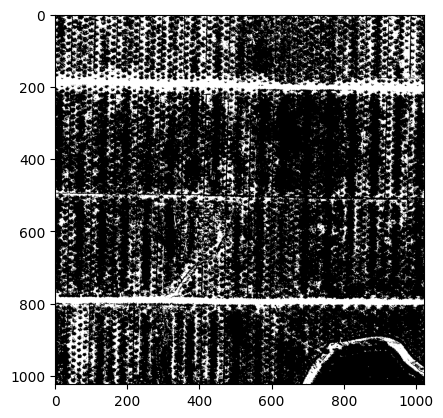

In [171]:
identified_roads = longest_component_identification(clustered_image)
plt.imshow(identified_roads, cmap='gray')
plt.show()

In [172]:
# Appyling dialation and erosion
def morphological_operations(img, k_d=2, itr_d=1, k_e=2, itr_e=1):
    image = np.array(img, dtype=np.uint8)
    kernel_e = np.ones((k_e,k_e), np.uint8)
    output_img = cv2.erode(image, kernel_e, iterations=itr_e)
    kernel_d = np.ones((k_d,k_d), np.uint8)
    output_img = cv2.dilate(output_img, kernel_d, iterations=itr_d)
    return output_img

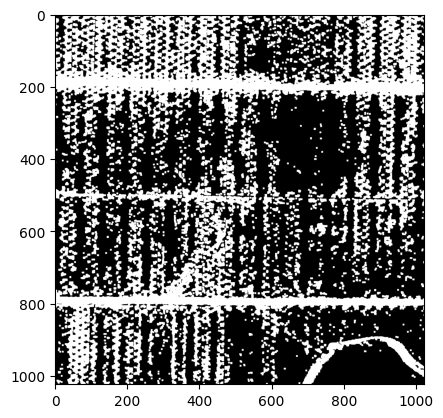

In [173]:
filtered_roads = morphological_operations(identified_roads,3,2,2,1)
plt.imshow(filtered_roads, cmap='gray')
plt.show()

In [174]:
# Removing non-road areas

#Function for 2Pass alogorithm 
#Input: Image for the dilation process or any image which has only 2 unique either
# foreground(1) or background(0)
#Output: Image after 2 pass alogrithm
def two_pass_algo(nodes_list,fly):
    r = len(nodes_list)
    c = len(nodes_list[0])
    dict_1 = {}
    labels = 0
    two_pass_arr = []
    for i in range(r):
        two_pass_temp = []
        for j in range(c):
            if(nodes_list[i][j] == 0):
                two_pass_temp.append(0)
            else:
                val_1 = 0
                val_2 = 0
                if((i-1)>=0):
                    val_1 = two_pass_arr[i-1][j]
                if((j-1)>=0):
                    val_2 = two_pass_temp[j-1]
                
                if(val_1 == 0 and val_2 == 0):
                    labels += 1
                    two_pass_temp.append(labels)
                elif(val_1 == val_2):
                    two_pass_temp.append(val_1)
                elif(val_1 == 0):
                    two_pass_temp.append(val_2)
                elif(val_2 == 0):
                    two_pass_temp.append(val_1)
                else:
                    two_pass_temp.append(min(val_1,val_2))
                    key_dict =  max(val_1,val_2)
                    value_dict = min(val_1,val_2)
                    if(key_dict in dict_1.keys()):
                        if(value_dict < dict_1[key_dict]):
                            dict_1[key_dict] = value_dict
                    elif(value_dict in dict_1.keys()):
                        dict_1[key_dict] = dict_1[value_dict]
                    else:
                      dict_1[key_dict] = value_dict
           
        two_pass_arr.append(two_pass_temp)
    
    for i in range(r):
        for j in range(c):
            key_1 =  two_pass_arr[i][j]
            if key_1 in dict_1.keys():
                two_pass_arr[i][j] =  dict_1[key_1]
    
    #print(len(np.unique(two_pass_arr)))

    dict_keys_two_pass_arary = {}
    
    for i in range(len(two_pass_arr)):
      for j in range(len(two_pass_arr[0])):
        if(two_pass_arr[i][j] != 0):
            if(two_pass_arr[i][j] not in dict_keys_two_pass_arary.keys()):
                dict_keys_two_pass_arary[two_pass_arr[i][j]] = 1
            else:
                dict_keys_two_pass_arary[two_pass_arr[i][j]] += 1
    
    dict_keys_two_pass_arary = dict(sorted(dict_keys_two_pass_arary.items(), key=lambda item: item[1]))
    key_dict_sorted = list(dict_keys_two_pass_arary.keys())
    len_keys = len(key_dict_sorted)
    
    final_keys = []
    for i in range(fly):
      #print(str(i))
      index = len_keys - i
      final_keys.append(key_dict_sorted[index-1])
    
    for i in range(len(two_pass_arr)):
      for j in range(len(two_pass_arr[0])):
        if(two_pass_arr[i][j] in final_keys):
          two_pass_arr[i][j] = 255
        else:
          two_pass_arr[i][j] = 0
      
    return two_pass_arr



def remove_nonroad_areas(dilated_image, num_clusters=2):
    r,c = dilated_image.shape
    dummy_v = []
    for i in range(r):
        t = []
        for j in range(c):
            if(dilated_image[i][j] == 255):
                t.append(1)
            else:
                t.append(0)
        dummy_v.append(t)
    #Call the solve method with clustered segemneted images as input
    ans = two_pass_algo(dummy_v,num_clusters)
    return ans

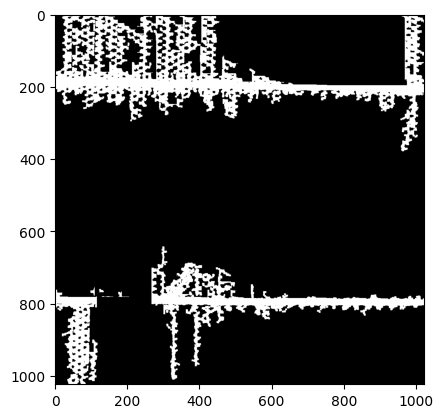

In [175]:
final_image = np.array(remove_nonroad_areas(filtered_roads,5))
plt.imshow(final_image, cmap='gray')
plt.show()